In [1]:
%matplotlib inline
from scipy.io import loadmat,savemat
from scipy.linalg import *
from numpy import *
from os import listdir
from random import choice
import pickle,operator,pandas
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [86]:
volumefraction = loadmat('alphatitaniummedium.mat')['volumefraction'][0]

### <font color="blue">Utility Functions </font>

In [27]:
def Plot(x,y,labelX="",labelY="",title="",size=(6,4)):
    choiceColor = str(choice(['r','b','y','c','g','m']))
    fig = plt.figure(figsize=size)
    plt.plot(x,y,choiceColor)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    
def posOdf(odf):
    return nonzero(odf)[0].tolist()

def printOdfVal(odf):
    List = posOdf(odf)
    for elem in List:
        print elem,':',odf[elem],
    print

def getSum(odf):
    Sum = 0
    for i in range(DIM):
        Sum += volumefraction[i]*odf[i]
    return Sum

def checkSum(odf):
    Sum = FiveSig(getSum(odf))
    if Sum !=1.0:
        return False
    else:
        return True
def FiveSig(x):
    return float("{0:.5f}".format(x))

def getAverage(odfs):
    List = []
    indices = list(range(DIM))
    for i in range(DIM):
        List += [0]

    for odf in odfs:
        nz = nonzero(odf)[0].tolist()
        for elem in nz:
            List[elem] += 1

    average = []
    for i in indices:
        average += [float(List[i])/float(len(odfs))]
    return average
        
def getTopAverage(odfs):
    topOdfs = odfs[:5000]
    topList = []
    indices = list(range(DIM))


    for i in range(DIM):
        topList += [0]

    for odf in topOdfs:
        nz = nonzero(odf)[0].tolist()
        for elem in nz:
            topList[elem] += 1

    topAverage = []
    for i in indices:
        topAverage += [float(topList[i])/float(len(topOdfs))]
    
    return topAverage

def loadData(name,path):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)

def saveData(obj, name,path):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)
            
def loadNumpy(name,path='numpyData'):
    fullPath = path+'/'+name+'.npy'
    return load(fullPath)
    

def saveNumpy(obj, name, path='numpyData'):
    fullPath = path+'/'+name
    save(fullPath, obj)
    print name,'saved successfully in',path

### <font color="purple"> Processing Data and Sorting </font>

In [106]:
data = []

Filename = []
for File in listdir('yieldUpperData'):

    Filename += [File]
    data += [loadmat('yieldUpperData/'+File)]

In [107]:
opts = []
odfs = []
constraint1 = []
constraint2 = []
DIM = 388
# sortedOpts = []
# sortedConstraints = []

maxOdf = [[0]*DIM]*len(data)#, maxOdf]#, maxOdf]#, maxOdf]
maxOpt = [0]*len(data)#4
maxConstraint1= [0]*len(data)
maxConstraint2 = [0]*len(data)

count = 0
total = 0

for i in range(len(data)):
    for odf in data[i]['Data']:
        
        odf = odf.tolist()
        opts += [odf[DIM+2]]
        constraint1 += [odf[DIM]]
        constraint2 += [odf[DIM+1]]
        
        odfs += [odf[:DIM]]
        
        total += 1
#         try: 
        if checkSum(odf[:DIM]):
            count += 1
            if odf[DIM+2]>maxOpt[i]:
                maxOpt[i] = odf[DIM+2]
                maxConstraint1[i] = odf[DIM]
                maxConstraint2[i] = odf[DIM+1]
                maxOdf[i] = odf[:DIM]

combined = zip(constraint1,constraint2,opts,odfs)
#combined.sort(key=lambda i: int(i[1]), reverse=True)
combined.sort(key=lambda x:map(float, str(float(x[2])).split(".")), reverse=True)
constraint1[:],constraint2[:],opts[:],odfs[:] = zip(*combined)         
            
        

### <font color="magenta">Top Near-Optimal Values</font>

In [98]:
for i in range(20):
    print opts[i], constraint1[i], constraint2[i], posOdf(odfs[i])

423.191114508 0.00713711582293 0.00975841051921 [337, 366]
422.335531023 0.00713477113361 0.00976749946771 [334, 344]
421.972983021 0.00710302110481 0.00979892107263 [308, 334]
421.038159804 0.00714513472483 0.00976190126764 [121, 337]
420.180526114 0.00695058738658 0.00992172085253 [295, 367]
420.019163767 0.00753935504882 0.00940773265858 [367, 385]
420.13137793 0.0069513854786 0.00991822938559 [71, 295]
417.86505116 0.00716342029334 0.00974589415631 [139, 334]
416.939740033 0.00754724313587 0.00941254681706 [339, 385]
416.925319808 0.00703608627687 0.00986837549418 [310, 337]
416.909610447 0.00729523802494 0.0096189561805 [295, 374]
415.406840116 0.00700114639865 0.00989948461219 [2, 295]
415.349491414 0.00722042014792 0.00965715914256 [81, 334]
415.315152735 0.00697022791694 0.00987205615321 [295, 322]
414.955369416 0.00743580931995 0.00950387442875 [369, 372]
414.955369412 0.00743726055257 0.00950562193797 [371, 374]
414.899784685 0.00740667091002 0.00953687504481 [310, 371]
414.6

### <font color="green"> Random Forest Regression to find the top features for determining value </font> 

In [99]:
edgeOdfs = odfs[:5000]+odfs[-5000:]
edgeLabels = opts[:5000]+opts[-5000:]

edgeOdfs,edgeLabels = shuffle(edgeOdfs,edgeLabels)
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(edgeOdfs, edgeLabels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [102]:
features = clf.feature_importances_
indices = argsort(features)[::-1]
values = sorted(features, reverse=True)
for i in range(8):
    print indices[i], ':',values[i]

371 : 0.32412982716
295 : 0.199742714024
350 : 0.133684756836
369 : 0.103744563826
308 : 0.0995596723387
331 : 0.0509311313574
244 : 0.0461761591142
332 : 0.0420311753435


### <font color="orange">Plots</font>

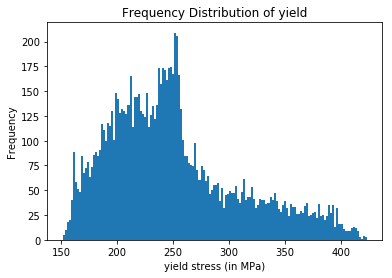

In [103]:
plt.hist(opts,bins=150)
plt.title("Frequency Distribution of yield")
plt.xlabel("yield stress (in MPa)")
plt.ylabel("Frequency")
plt.show()

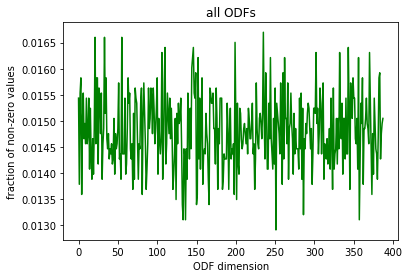

In [104]:
indices = list(range(388))
List = []
for i in range(388):
    List += [0]
    
for odf in odfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(odfs))]
Plot(indices, average,"ODF dimension","fraction of non-zero values","all ODFs")

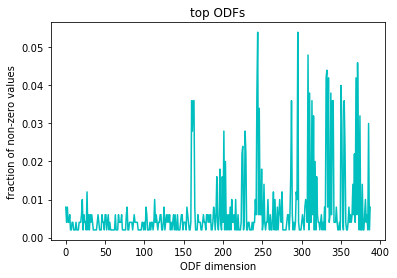

In [105]:
indices = list(range(388))
topOdfs = odfs[:500]
topList = []
for i in range(388):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","top ODFs")